In [32]:
import pandas as pd
import os
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.dummy import DummyClassifier
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import pickle
from numpy.random import seed
from sklearn.neighbors import KNeighborsClassifier
seed(3)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nelsonlim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
# change
BINANCE_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/binance/processed/day_discrete"
TWITTER_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/twitter"
REDDIT_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/reddit"

TWITTER_FILE = "twitter.csv"
REDDIT_FILE  = "reddit.csv"
BINANCE_FILE = None

FIGURE_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/notebook/img"
SAVE_FIG = False

# SAVED MODELS & VARIABLES
COUNT_VECTORISER_FILE = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/count_vectoriser.pkl" # x
COUNT_VECTORISER_VAR_FILE = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/count_vectoriser_var.pkl" # vectorizer data
SVM_FILE = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/SVM_model.pkl"
KNN_MODELS_CV_K = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/KNN_models_cv_k.pkl"
KNN_FILE = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/KNN_model.pkl"

# dont change
BINANCE_EXTENSION = "csv"

START_DATE = "2018-01-01"
END_DATE = "2021-10-31"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def concatenate_content_values(content_list):
	return content_list.str.cat(sep=" ")

# Dataset

### Binance

In [7]:
if BINANCE_FILE is None:
    # load binance data
    df_binance_list = []
    for filename in sorted(os.listdir(BINANCE_DIR)):
        if filename.endswith(BINANCE_EXTENSION):
            df_binance_list.append(pd.read_csv( os.path.join(BINANCE_DIR,filename)))
    df_binance = pd.concat(df_binance_list,ignore_index=True)

    # convert time to date obj
    df_binance['time'] = pd.to_datetime(df_binance['time'])

    # change index to time
    df_binance = df_binance.set_index('time')

    # filter date range
    df_binance = df_binance.loc[START_DATE:END_DATE]
else:    
    # load binance data
    df_binance = pd.read_csv(  os.path.join(BINANCE_DIR, BINANCE_FILE), lineterminator='\n' )

    # convert time to date obj
    df_binance['time'] = pd.to_datetime(df_binance['time'])

    # change index to time
    df_binance = df_binance.set_index('time')

    # filter date range
    df_binance = df_binance.loc[START_DATE:END_DATE]

run this


In [9]:
price_mean = df_binance['price_mean']
binance_time = df_binance.index.strftime("%m/%d/%y").values
plot_x = range(len(binance_time))

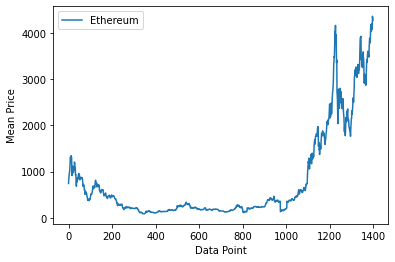

In [12]:
plt.plot(plot_x, price_mean)   
plt.legend(['Ethereum'])
plt.xlabel("Data Point")
plt.ylabel("Mean Price")
if SAVE_FIG:
    plt.savefig(os.path.join(FIGURE_DIR,"binance_mean_price"))
plt.show()    

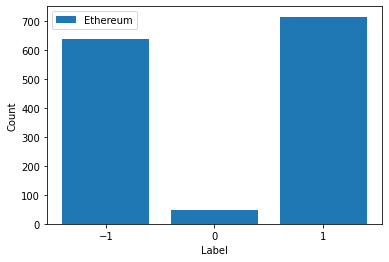

In [13]:
labels = Counter(df_binance['label'].values)
labels_keys = list(labels.keys())
labels_values = list(labels.values())

plt.bar(labels_keys, labels_values)
plt.xticks(labels_keys)
plt.legend(['Ethereum'])
plt.xlabel("Label")
plt.ylabel("Count")
if SAVE_FIG:
    plt.savefig(os.path.join(FIGURE_DIR,"binance_label"))
plt.show()

### Reddit

In [14]:
# read reddit
df_reddit = pd.read_csv(  os.path.join(REDDIT_DIR, REDDIT_FILE), lineterminator='\n' )

# convert to date obj
df_reddit['date'] = pd.to_datetime(df_reddit['date'])

# Join all reddit posts for each day into one big string
df_reddit = df_reddit.groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

# filter date range
df_reddit = df_reddit.loc[START_DATE:END_DATE]

In [15]:
df_reddit.head()

,content,popularity
date,,
2018-01-01,how you do it? i cant change the onboard to pc...,2.104167
2018-01-02,"If you have nvidia experience, it'll prompt yo...",2.432655
2018-01-03,&gt; I'm getting pretty low hashrates on my ri...,1.912791
2018-01-04,http://brianford.tech/2017-10-10-etherMiningRi...,2.580911
2018-01-05,Currently I'm on wifi. I hear ethermine mines ...,2.102229


### Twitter

In [16]:
# load twitter data
df_twitter = pd.read_csv( os.path.join(TWITTER_DIR, TWITTER_FILE), lineterminator="\n")

# convert to date obj
df_twitter['date'] = pd.to_datetime(df_twitter['date'])

# Join all tweets for each day into one big string
df_twitter = df_twitter.groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

# filter date range
df_twitter = df_twitter.loc[START_DATE:END_DATE]

In [17]:
df_twitter.head()

,content,popularity
date,,
2018-01-01,#Ethereum trade bot is attempting to sell. Cur...,0.049917
2018-01-02,#AIRDROP #EtherFlip #FLIP #LIVE @Ethereum_Flip...,0.012856
2018-01-03,#AIRDROP #EtherFlip #FLIP #LIVE @Ethereum_Flip...,0.068100
2018-01-04,Estonian enterprises will use the Ethereum blo...,0.025132
2018-01-05,Update: took 10 hours for my Ethereum payment ...,0.077095


In [18]:
input_data = pd.concat([df_reddit,df_twitter]).groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

In [19]:
daily_content = input_data.content

In [20]:
daily_content

date
2018-01-01    how you do it? i cant change the onboard to pc...
2018-01-02    If you have nvidia experience, it'll prompt yo...
2018-01-03    &gt; I'm getting pretty low hashrates on my ri...
2018-01-04    http://brianford.tech/2017-10-10-etherMiningRi...
2018-01-05    Currently I'm on wifi. I hear ethermine mines ...
                                    ...                        
2021-10-27    Oh that little thing on the wall is a fan on.\...
2021-10-28    Here are my OC and voltage settings for my FE_...
2021-10-29    I have 6 hynix memory 3060ti’s that say otherw...
2021-10-30    ROI is equally sentimental and doesn’t pertain...
2021-10-31    Whattomine will tell you better than anyone on...
Name: content, Length: 1400, dtype: object

## Preprocess Data

In [21]:
# check if there exist any empty column
daily_content.isna().sum()

0

## Prunning

In [22]:
stemmer = PorterStemmer()

# Adding stemmming with CountVectorizer
# https://stackoverflow.com/questions/36182502/add-stemming-support-to-countvectorizer-sklearn
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    words = []
    for w in analyzer(doc):
        
        # remove words with number
        if len(re.findall('\d+', w)) > 0:
            continue
        
        # only english letters
        w=re.sub('[^a-zA-Z]','',w)    
        if w == '':
            continue
        
        # stemming 
        stemmed_word = stemmer.stem(w)
        
        words.append(stemmed_word)
    return words

In [23]:
# read
with open(COUNT_VECTORISER_VAR_FILE, 'rb') as f:
    vectorizer = pickle.load(f)

In [24]:
# read
with open(COUNT_VECTORISER_FILE, 'rb') as f:
    x = pickle.load(f)

In [ ]:
# prunning
vectorizer = CountVectorizer(
    ngram_range=(1, 1),
    stop_words=nltk.corpus.stopwords.words("english"),
    min_df=0.1,
    max_df=1.0,
    analyzer=stemmed_words
)

x = vectorizer.fit_transform(daily_content)

# write
with open(COUNT_VECTORISER_VAR_FILE, 'wb') as fout:
    pickle.dump(vectorizer, fout)
    
# write
with open(COUNT_VECTORISER_FILE, 'wb') as fout:
    pickle.dump(x, fout)

In [25]:
print(f"{len(vectorizer.get_feature_names())} features")

7176 features


In [26]:
y = df_binance.label

### Training

In [27]:
y[y == 0] = 1

In [28]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2)

In [40]:
knn_model = []
mean_error = []
std_error = []
k_range = range(5,701, 10)

for index, k in enumerate(k_range):    
    knn_model.append( KNeighborsClassifier(n_neighbors=k, weights='uniform') )
    temp = []
    kf = KFold(n_splits=5)
    for train,test in kf.split(Xtrain):
        knn_model[index].fit(Xtrain[train], ytrain[train])
        ypred = knn_model[index].predict(Xtrain[test])
        temp.append( f1_score(ytrain[test], ypred) )
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())

In [41]:
# write
with open(KNN_MODELS_CV_K, 'wb') as fout:
    pickle.dump(knn_model, fout)

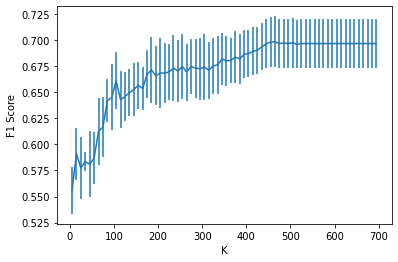

In [42]:
fig = plt.figure()
plt.errorbar(k_range, mean_error, yerr=std_error)
plt.xlabel('K')
plt.ylabel('F1 Score')
plt.savefig(os.path.join(FIGURE_DIR,"knn_cv_k"))
plt.show()

In [53]:
optimal_k = k_range[np.argmax(mean_error)]
print(optimal_k)

465


In [54]:
FIXED_k = 465

knn_model = KNeighborsClassifier(n_neighbors=FIXED_k, weights='uniform')
knn_model.fit(Xtrain, ytrain)

KNeighborsClassifier(n_neighbors=465)

In [55]:
# write
with open(KNN_FILE, 'wb') as fout:
    pickle.dump(knn_model, fout)

In [56]:
ypred = knn_model.predict(Xtest)
print(classification_report(ytest,ypred))
print(confusion_matrix(ytest,ypred))

              precision    recall  f1-score   support

        -1.0       0.36      0.03      0.06       118
         1.0       0.58      0.96      0.72       162

    accuracy                           0.57       280
   macro avg       0.47      0.50      0.39       280
weighted avg       0.49      0.57      0.44       280

[[  4 114]
 [  7 155]]


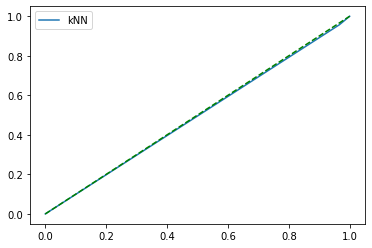

In [58]:
model = knn_model
fpr_knn, tpr_knn, _ = roc_curve(ytest, model.predict(Xtest))
plt.plot(fpr_knn,tpr_knn)
plt.plot([0,1],[0,1], color='green', linestyle='--')
plt.legend(['kNN'])
plt.savefig(os.path.join(FIGURE_DIR, "roc_knn"),bbox_inches='tight')
plt.show()

In [60]:
auc_knn = roc_auc_score(ytest, model.predict(Xtest))
print('kNN AUC:',auc_knn)

kNN AUC: 0.49534421427076797


# Baselines

In [61]:
# most frequent
common_baseline_model = DummyClassifier(strategy="most_frequent")
common_baseline_model.fit(Xtrain, ytrain)
common_baseline_prediction = common_baseline_model.predict(Xtest)
print(classification_report(ytest,common_baseline_prediction))
print(confusion_matrix(ytest,common_baseline_prediction))

auc_common = roc_auc_score(ytest, common_baseline_model.predict(Xtest))
print('common AUC:',auc_common)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       118
         1.0       0.58      1.00      0.73       162

    accuracy                           0.58       280
   macro avg       0.29      0.50      0.37       280
weighted avg       0.33      0.58      0.42       280

[[  0 118]
 [  0 162]]
common AUC: 0.5


/Users/nelsonlim/.virtualenv/tcd_ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nelsonlim/.virtualenv/tcd_ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nelsonlim/.virtualenv/tcd_ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [65]:
random_baseline_model = DummyClassifier(strategy="uniform", random_state=1 )
random_baseline_model.fit(Xtrain, ytrain)
random_baseline_prediction = random_baseline_model.predict(Xtest)
print(classification_report(ytest,random_baseline_prediction))
print(confusion_matrix(ytest,random_baseline_prediction))

auc_random = roc_auc_score(ytest, random_baseline_model.predict(Xtest))
print('random AUC:',auc_random)

              precision    recall  f1-score   support

        -1.0       0.44      0.50      0.47       118
         1.0       0.60      0.54      0.56       162

    accuracy                           0.52       280
   macro avg       0.52      0.52      0.52       280
weighted avg       0.53      0.52      0.52       280

[[59 59]
 [75 87]]
random AUC: 0.5185185185185186


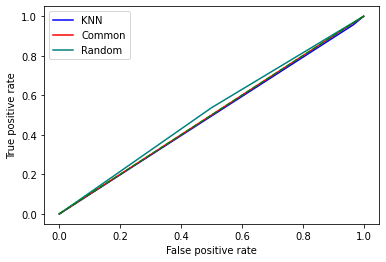

In [66]:
fpr_common, tpr_common, _ = roc_curve(ytest, common_baseline_model.predict(Xtest))
fpr_random, tpr_random, _ = roc_curve(ytest, random_baseline_model.predict(Xtest))
plt.plot(fpr_knn,tpr_knn, c='blue')
plt.plot(fpr_common,tpr_common, c='red')
plt.plot(fpr_random,tpr_random, c='teal')
plt.plot([0,1],[0,1], color='green', linestyle='--')
plt.legend(['KNN', "Common", "Random"])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.savefig(os.path.join(FIGURE_DIR, "knn_with_baselines"),bbox_inches='tight')
plt.show()